In [ ]:
# Github Link : https://github.com/AnkitaSavaliya/AIH/blob/main/MIMIC_III_NLP.ipynb

In [2]:
import pandas as pd
from google.cloud import bigquery

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install spacy==3.7.5
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_sci_md: filename=en_core_sci_md-0.5.4-py3-none-any.whl size=119157919 sha256=b8201507b97bf14ca8485ed7ecd8f2799b6b67b053869a23a1ecd6b8944d83d2
  Stored in directory: /root/.cache/pip/wheels/95/1a/ef/15bb75408932773f77493af403541968b81ebce363f4dc9fdd
Successfully built en_core_sci_md
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_ner_bc5cdr_md: filename=en_ner_bc5cdr_md-0.5.4-py3-none-any.whl size=119787678 sha256=3ab923cb773bbdf9

### Fetching and Filtering Data of noteevents

In [5]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

!gcloud projects list

from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client(project='clinical-entity-extraction')

"""
ICD codes related to Hypertension:
 4010 - Malignant essential hypertension
 4011 - Benign essential hypertension
 4019 - Unspecified essential hypertension
"""
# Fetch notes only for ICD-9 code 4010(Malignant essential hypertension)
query = """
   SELECT SUBJECT_ID, TEXT, CATEGORY
    FROM `physionet-data.mimiciii_notes.noteevents`
    WHERE SUBJECT_ID IN (
        SELECT d.SUBJECT_ID
        FROM `physionet-data.mimiciii_clinical.diagnoses_icd` d
        WHERE d.ICD9_CODE = '4010' -- Hypertension code
        AND d.SEQ_NUM = 1  -- Assuming 1 indicates primary diagnosis
    )
    AND CATEGORY LIKE 'Discharge summary';
"""

# Run the query
query_job = client.query(query)

# Print the results
noteevents_df = query_job.to_dataframe()

len(noteevents_df)

Authenticated
PROJECT_ID                  NAME                        PROJECT_NUMBER
clinical-entity-extraction  clinical-entity-extraction  321960627270


162

In [6]:
patients_dict = {"SUBJECT_ID":[],"CATEGORY":[],"TEXT":[]};
for i in range(0, len(noteevents_df)):
   patients_dict["SUBJECT_ID"].append(noteevents_df.loc[i, 'SUBJECT_ID'])
   patients_dict["CATEGORY"].append(noteevents_df.loc[i, 'CATEGORY'])
   patients_dict["TEXT"].append(noteevents_df.loc[i, 'TEXT'])

patients_df = pd.DataFrame(patients_dict)

In [7]:
patients_df.shape

(162, 3)

In [8]:
#print first few records
patients_df.head(2)

,SUBJECT_ID,CATEGORY,TEXT
0,109,Discharge summary,Admission Date: [**2140-1-19**] ...
1,109,Discharge summary,Admission Date: [**2142-7-12**] ...


In [9]:
# Download the patients_df dataframe in .csv and excel format
patients_df.to_csv(r'Patient_Summary_4010.csv', index = False)
patients_df.to_excel("Patient_Summary_4010.xlsx")

In [10]:
# Copy Processed data to google drive
!cp 'Patient_Summary_4010.csv' '/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010.csv'
!cp 'Patient_Summary_4010.xlsx' '/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010.xlsx'

### Functions to clean text and extract tokens and entities.

In [11]:
! python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 66.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [12]:
import spacy

# Function to clean and extract tokens
def extract_cleaned_text(text, nlp_model):
    doc = nlp_model(str(text))
    tokens = [token.text for token in doc if not token.is_punct and not token.is_space and not token.is_stop]
    return " ".join(tokens)  # Return cleaned text as a string

In [63]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

def tsne_plot(model, words, words_limit = None, model_title="", preTrained=False):
    """
    Creates and displays two t-SNE plots:
    1. Simple scatter plot with labels.
    2. Scatter plot with distance-based coloring.

    Parameters:
    - model: The Word2Vec model or pre-trained model.
    - words: List of words to visualize.
    - words_limit : Limit the number of words to visualize.
    - model_title: Title of the model.
    - preTrained: Boolean flag to choose between Word2Vec or pre-trained model.
    """
    labels = []
    tokens = []

    # Apply t-SNE for dimensionality reduction
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', max_iter=1000, random_state=23)

    # Prepare tokens and labels
    for word in words[:words_limit]:
        if preTrained:
            tokens.append(model[word])  # Pre-trained word vectors
        else:
            tokens.append(model.wv[word])  # Word2Vec model vectors
        labels.append(word)

    tokens = np.array(tokens)
    new_values = tsne_model.fit_transform(tokens)

    x = new_values[:, 0]
    y = new_values[:, 1]

    # First plot: Scatter plot with annotations
    plt.figure(figsize=(16,12))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title(f"t-SNE Visualization for {model_title}")
    plt.show()

def tsne_plot_no_label(model, words, words_limit=None, model_title="", preTrained=False, reference_word=None):
    """
    Creates and displays a t-SNE plot without labels, using color mapping based on distance.

    Parameters:
    - model: The Word2Vec model or pre-trained model.
    - words: List of words to visualize.
    - words_limit: Maximum number of words to visualize.
    - model_title: Title of the model (used for plot labeling).
    - preTrained: Boolean flag indicating whether to use a pre-trained model.
    - reference_word: (Unused in this function) Placeholder for potential relevance-based coloring.
    """
    tokens = []

    # Apply t-SNE for dimensionality reduction
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', max_iter=1000, random_state=23)

    # Extract word vectors
    for word in words[:words_limit]:
        if preTrained:
            tokens.append(model[word])  # Use vectors from a pre-trained model
        else:
            tokens.append(model.wv[word])  # Use vectors from a Word2Vec model

    tokens = np.array(tokens)
    new_values = tsne_model.fit_transform(tokens)

    # Create a scatter plot with color based on distance from the origin
    plt.figure(figsize=(10, 8))
    distances = np.sqrt(new_values[:, 0]**2 + new_values[:, 1]**2)  # Compute Euclidean distance from origin
    plt.scatter(new_values[:, 0], new_values[:, 1], c=distances, cmap='plasma')
    plt.colorbar(label="Distance from Origin")  # Add a color bar for reference
    plt.title(f"t-SNE Visualization with Distance-Based Coloring for {model_title}")
    plt.show()



In [14]:
import spacy

def build_corpus(df, model="en_core_web_sm"):
    """
    Extracts named entities from the specified text column in a DataFrame using a spaCy model,
    builds a corpus.

    Parameters:
    - df (pd.DataFrame): DataFrame containing text data.
    - text_column (str): Column name containing processed text.
    - model (str): spaCy model to use (default: "en_core_web_sm").

    Returns:
    - corpus (list of lists): Extracted entities per document.
    """
    nlp = model
    corpus = []

    for _, row in df.iterrows():
        tokens = [ent.text for ent in nlp(row["Processed_Text"]).ents]
        corpus.append(tokens)

    # Calculate word counts
    word_counts = [len(doc) for doc in corpus]

    return corpus

## Using Spacy

In [15]:
import pandas as pd

#Load Patient Discharge summary
patients_df_scapy = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010.csv")

# Load the spacy model
nlp_spacy = spacy.load('en_core_web_sm')

# Apply token extraction
patients_df_scapy["Processed_Text"] = patients_df_scapy["TEXT"].apply(lambda text: extract_cleaned_text(text, nlp_spacy))

#Copy Processed data to google drive
patients_df_scapy.to_csv(r'Patient_Summary_4010_Spacy.csv', index = False)
!cp 'Patient_Summary_4010_Spacy.csv' '/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010_Spacy.csv'

In [16]:
import pandas as pd
# Load the processed patient data with spacy
patients_df_scapy = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010_Spacy.csv")

nlp_spacy = spacy.load('en_core_web_sm')  # Load the specified NLP model

print(patients_df_scapy.shape)

(162, 4)


In [17]:
doc = nlp_spacy( patients_df_scapy['Processed_Text'][0])
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

2117 61 65 DATE
2297 143 147 DATE
Known 248 253 PERSON
22 year old 263 274 DATE
ESRD 302 306 ORG
TTP 328 331 ORG
Awoke a.m. 370 380 ORG
HA 405 407 ORG
Monday 439 445 DATE
HTN Decided 450 461 ORG
SOB + Diarrhea 545 559 ORG
1 day 562 567 DATE
217/140 579 586 CARDINAL
254/152 596 603 CARDINAL
1 636 637 CARDINAL
208 671 674 CARDINAL
50 mg x 704 711 QUANTITY
1 712 713 CARDINAL
193/134 755 762 CARDINAL
CXR 845 848 ORG
ROS 862 865 ORG
past week 871 880 DATE
SOB N V + 898 907 ORG
BP 191/126 939 949 ORG
2 1118 1119 CARDINAL
ESRD 1120 1124 ORG
SLE 1134 1137 ORG
2135 1138 1142 CARDINAL
1 1161 1162 CARDINAL
3 months 2 years 1168 1184 DATE
3 1200 1201 CARDINAL
3 1267 1268 CARDINAL
2137 1273 1277 DATE
1 1303 1304 CARDINAL
4 1352 1353 CARDINAL
2137 1393 1397 DATE
6 1398 1399 CARDINAL
2139 1417 1421 DATE
20 1424 1426 CARDINAL
7 1427 1428 CARDINAL
8 1466 1467 CARDINAL
9 1475 1476 CARDINAL
Staph 1486 1491 PERSON
6 1521 1522 CARDINAL
10 1526 1528 CARDINAL
Social History Lives Location 1557 1586 ORG
669 1

In [61]:
from spacy import displacy

# Note: Displaying all data points is causing the notebook to become oversized, unable to check-in
# Visualize named entities using displacy for first few notes
for i in range(0, 3):
    doc = nlp_spacy( patients_df_scapy['Processed_Text'][i])
    displacy.render(doc, style="ent")
    print("*************************")


*************************


*************************


*************************


### Word2Vec and t-SNE Visualization Using SpaCy-Processed Data

In [19]:
from gensim.models import Word2Vec

#Build corpus for all the notes
corpus_spacy = build_corpus(patients_df_scapy, nlp_spacy)

In [20]:
model_word2vec_spacy = Word2Vec(corpus_spacy, min_count=3)

In [21]:
model_word2vec_spacy.wv.similar_by_key("BP"), model_word2vec_spacy.wv.similar_by_key("Clonidine")

([('CT', 0.9998685121536255),
  ('MICU', 0.9998401403427124),
  ('IVC', 0.9998314380645752),
  ('EKG', 0.9998312592506409),
  ('RA', 0.9998170137405396),
  ('IV', 0.9998096227645874),
  ('CXR', 0.9998014569282532),
  ('Family History', 0.9997963309288025),
  ('Known', 0.9997953772544861),
  ('CK', 0.9997934699058533)],
 [('3', 0.9996775388717651),
  ('25', 0.9996731281280518),
  ('100', 0.9996365308761597),
  ('PO', 0.999612033367157),
  ('30', 0.9995716214179993),
  ('50', 0.9995605945587158),
  ('200', 0.9995548725128174),
  ('6', 0.9995482563972473),
  ('7', 0.9995362758636475),
  ('10', 0.9995243549346924)])

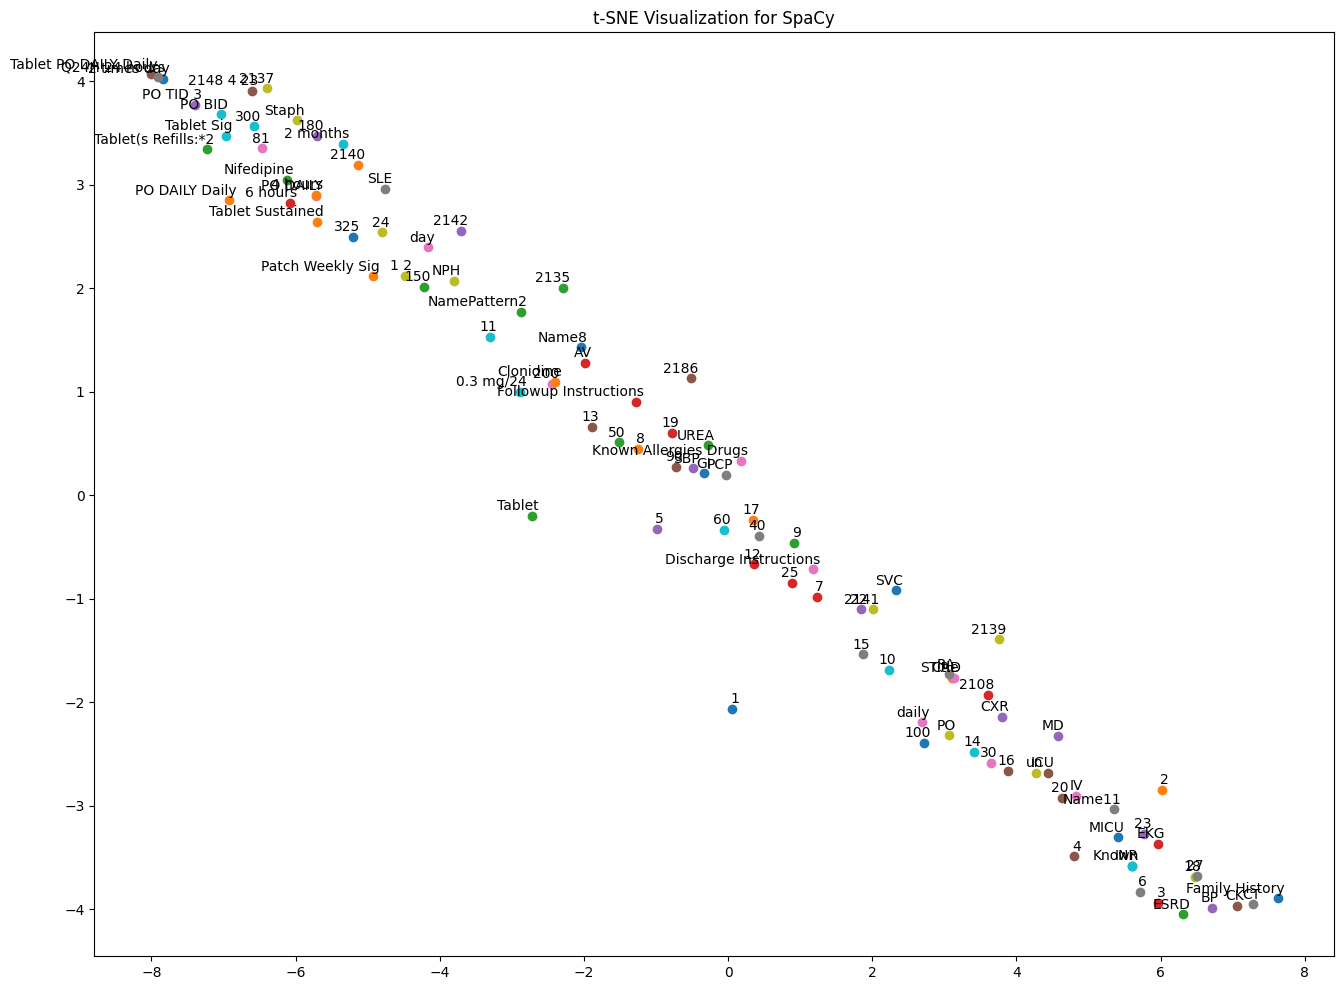

In [22]:
tsne_plot(model_word2vec_spacy, np.array(list(model_word2vec_spacy.wv.key_to_index.keys())), 100, 'SpaCy')

In [23]:
len(model_word2vec_spacy.wv.key_to_index.keys())

1605

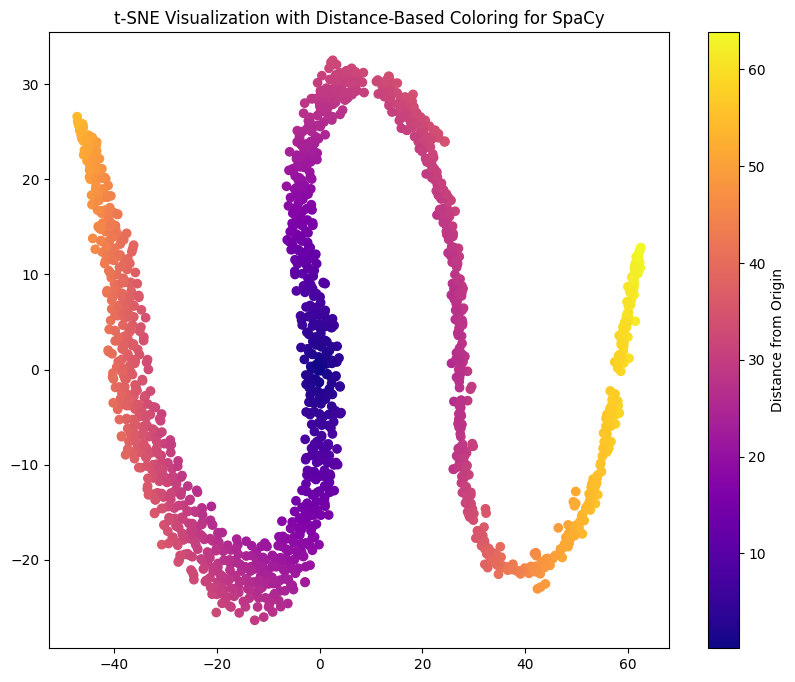

In [24]:
tsne_plot_no_label(model_word2vec_spacy, np.array(list(model_word2vec_spacy.wv.key_to_index.keys())), None, 'SpaCy')

## Using SciSpacy


In [25]:
import pandas as pd
import scispacy
import spacy

#Load Patient Discharge summary
patients_df_SciSpaCy = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010.csv")

nlp_SciSpaCy = spacy.load('en_core_sci_md')  # Load the specified NLP model
# Apply token extraction
patients_df_SciSpaCy["Processed_Text"] = patients_df_SciSpaCy["TEXT"].apply(lambda text: extract_cleaned_text(text, nlp_SciSpaCy))

#Copy Processed data to google drive
patients_df_SciSpaCy.to_csv(r'Patient_Summary_4010_SciSpacy.csv', index = False)
!cp 'Patient_Summary_4010_SciSpacy.csv' '/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010_SciSpacy.csv'

In [26]:
import pandas as pd
import scispacy
import spacy

nlp_SciSpaCy = spacy.load('en_core_sci_md')

#Load Processed SciSpacy
patients_df_SciSpaCy = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_4010_SciSpacy.csv")

In [27]:
from spacy import displacy

# Visualize named entities using displacy for first few notes
# Note: Displaying all data points is causing the notebook to become oversized, unable to check-in
for i in range(0, 3):
    doc = nlp_SciSpaCy( patients_df_SciSpaCy['Processed_Text'][i])
    displacy.render(doc, style="ent", jupyter=True)
    print("**************************************")

**************************************


**************************************


**************************************


### Word2Vec and t-SNE Visualization Using SciSpaCy-Processed Data

In [28]:
from gensim.models import Word2Vec

corpus_scispacy = build_corpus(patients_df_SciSpaCy, nlp_SciSpaCy)

In [29]:
model_word2vec_scispacy = Word2Vec(corpus_scispacy, min_count=3)

In [30]:
model_word2vec_scispacy.wv.similar_by_key("BP"), model_word2vec_scispacy.wv.similar_by_key("Clonidine")

([('HR', 0.9993711709976196),
  ('admitted', 0.9993606805801392),
  ('MICU', 0.9992586374282837),
  ('RR', 0.9992402791976929),
  ('gastroparesis', 0.9992167353630066),
  ('patient', 0.9991229176521301),
  ('ED', 0.9990416169166565),
  ('symptoms', 0.9990056753158569),
  ('HTN', 0.998991072177887),
  ('HD', 0.9989602565765381)],
 [('Patch', 0.9993199706077576),
  ('Lisinopril', 0.998427152633667),
  ('Patch Weekly Sig 1', 0.9981398582458496),
  ('Prednisone', 0.997868537902832),
  ('Transdermal QWED', 0.9976481795310974),
  ('Labetalol', 0.9975727200508118),
  ('Aspirin', 0.9974137544631958),
  ('Amlodipine', 0.9971833229064941),
  ('Metoclopramide', 0.9970840811729431),
  ('Refills:*0', 0.99689781665802)])

In [60]:
len(model_word2vec_scispacy.wv.key_to_index.keys())

3276

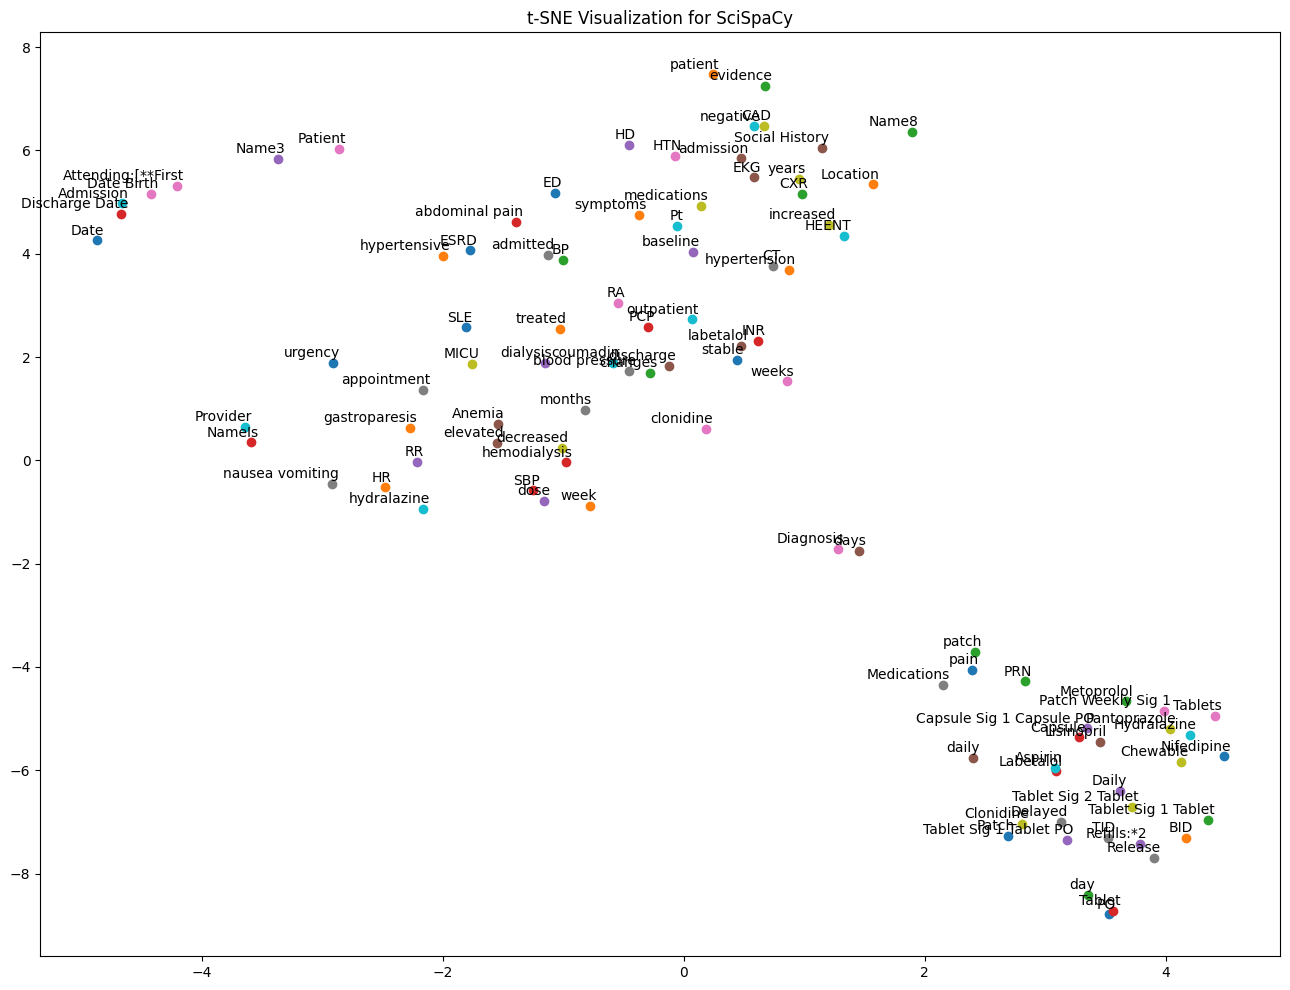

In [31]:
tsne_plot(model_word2vec_scispacy, np.array(list(model_word2vec_scispacy.wv.key_to_index.keys())), 100, 'SciSpaCy')

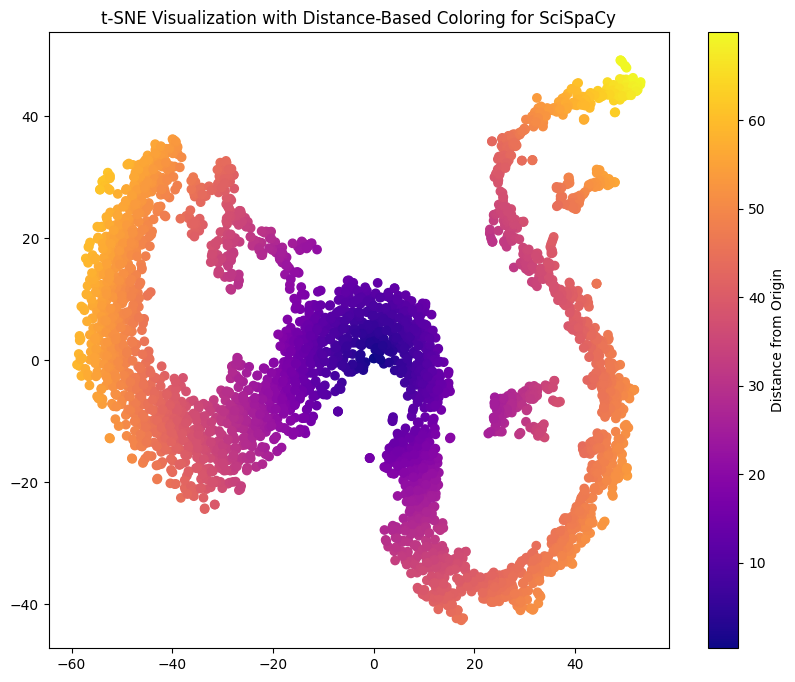

In [32]:
tsne_plot_no_label(model_word2vec_scispacy, np.array(list(model_word2vec_scispacy.wv.key_to_index.keys())), None, 'SciSpaCy')


### en_ner_bc5cdr_md Visualization Using SciSpaCy-Processed Data.
  
*   It is a SciSpaCy model, not a standard SpaCy model. It is specifically trained for biomedical named entity recognition (NER), focusing on diseases and chemicals.

In [64]:
import en_ner_bc5cdr_md
import spacy
from spacy import displacy

nlp__bc5cdr = en_ner_bc5cdr_md.load()

# Note: Displaying all data points is causing the notebook to become oversized, unable to check-in
# Visualize named entities using displacy for first few notes
for i in range(0, 3):
    doc = nlp__bc5cdr( patients_df_SciSpaCy['Processed_Text'][i])
    displacy.render(doc, style="ent", jupyter=True)
    print("**************************************")


**************************************


**************************************


**************************************


In [34]:
from gensim.models import Word2Vec
corpus_bc5cdr = build_corpus(patients_df_SciSpaCy, nlp__bc5cdr)

In [35]:
model_word2vec_bc5cdr = Word2Vec(corpus_bc5cdr, min_count=3, window=2, vector_size=100)

In [36]:
model_word2vec_bc5cdr.wv.similar_by_word("BP"), model_word2vec_bc5cdr.wv.similar_by_word("Clonidine")

([('qid', 0.7542693614959717),
  ('Lactate', 0.7493560910224915),
  ('CP', 0.7465789914131165),
  ('papilledema', 0.745745837688446),
  ('atrial fibrillation', 0.7431225180625916),
  ('reglan', 0.7429000735282898),
  ('pleural effusions', 0.7415630221366882),
  ('Carvedilol', 0.740106999874115),
  ('fentanyl', 0.7399438619613647),
  ('coronary artery disease', 0.7399159073829651)],
 [('hypertension', 0.9987433552742004),
  ('pain', 0.9987409114837646),
  ('Aspirin', 0.998708963394165),
  ('Labetalol', 0.9986240267753601),
  ('hypertensive', 0.9985849857330322),
  ('abdominal pain', 0.9985615611076355),
  ('Lisinopril', 0.9985013604164124),
  ('chest pain', 0.9984785914421082),
  ('HTN', 0.9983934760093689),
  ('ESRD', 0.9983604550361633)])

In [59]:
len(model_word2vec_bc5cdr.wv.key_to_index.keys())

885

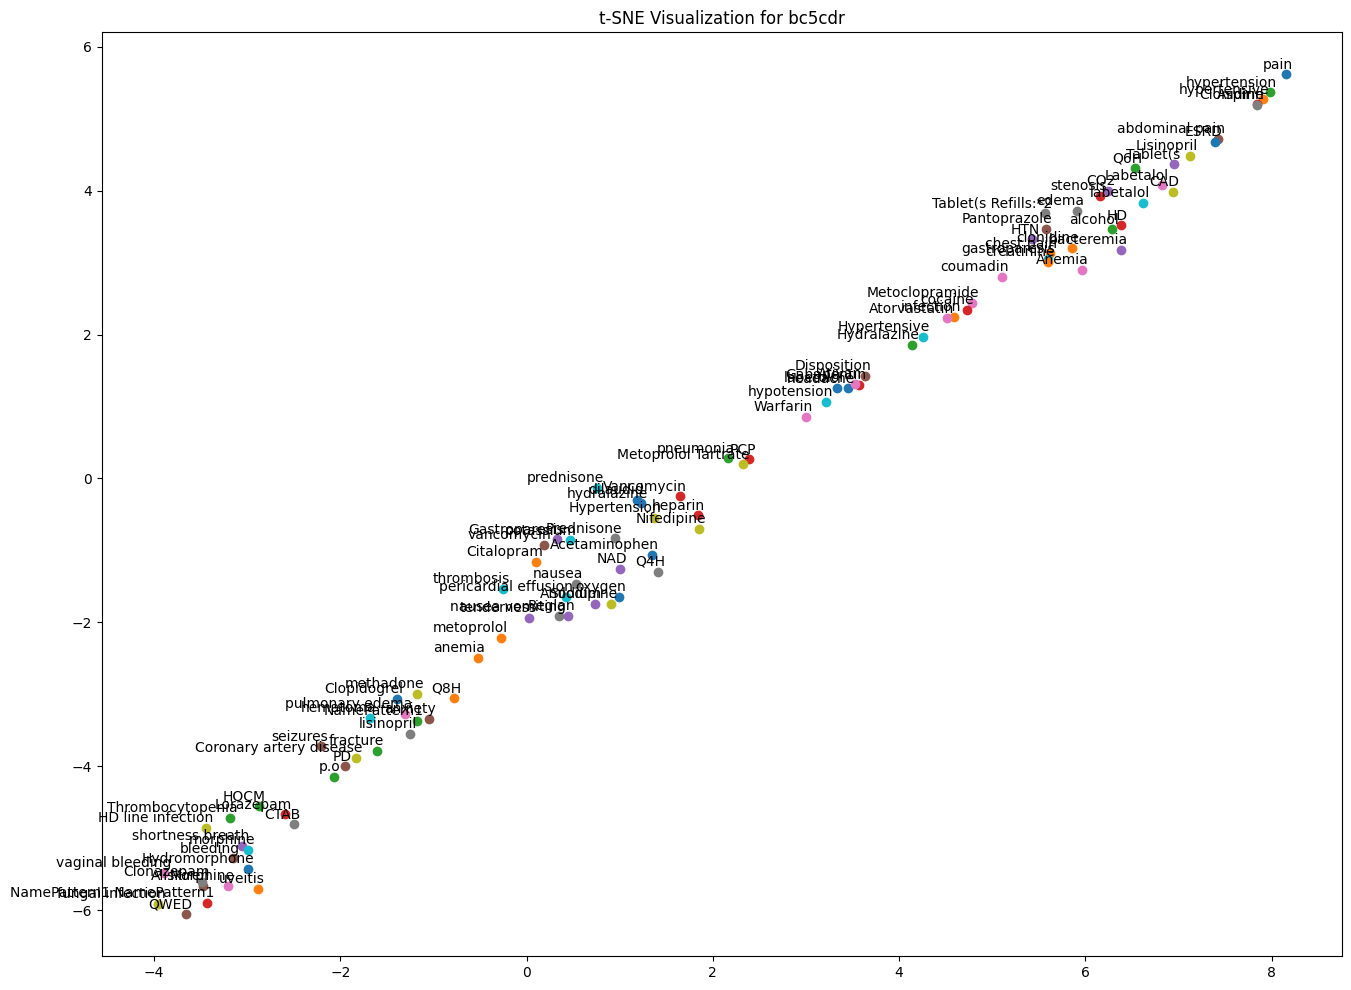

In [37]:
tsne_plot(model_word2vec_bc5cdr,np.array(list(model_word2vec_bc5cdr.wv.key_to_index.keys())), 100, 'bc5cdr')

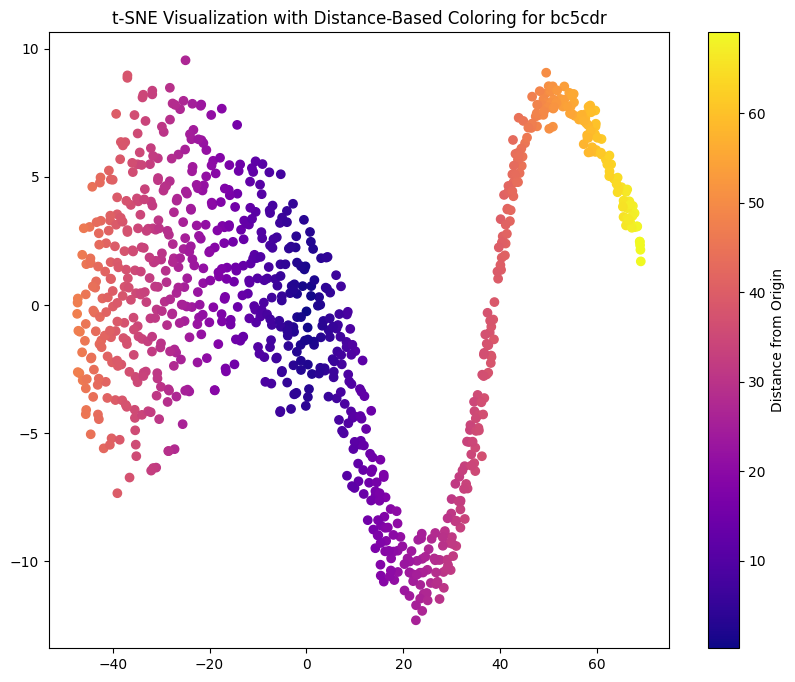

In [38]:
tsne_plot_no_label(model_word2vec_bc5cdr,np.array(list(model_word2vec_bc5cdr.wv.key_to_index.keys())), None, 'bc5cdr')

### MedSpacy Visualization Using SciSpaCy-Processed Data.

In [42]:
!pip install medspacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.7/419.7 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 26.8 MB/s eta 0:00:00
  Created wheel for medspacy: filename=medspacy-1.3.1-py3-none-any.whl size=313657 sha256=78af377f8b0b217d1f3fd0c38f300ac5ef197a5e37f35e8e1f164

In [62]:
import medspacy
from spacy import displacy
from medspacy.ner import TargetRule
from medspacy.visualization import visualize_ent

# Load MedspaCy NLP pipeline
nlp_medspacy = medspacy.load()

# Add rules for target concept extraction
target_matcher = nlp_medspacy.get_pipe("medspacy_target_matcher")
# Define custom rules for better entity detection
target_rules = [
    TargetRule("hyperlipidemia", "DISEASE"),
    TargetRule("O2", "SUBSTANCE"),
    TargetRule("FiO2", "SUBSTANCE"),
    TargetRule("hypertension", "DISEASE"),
    TargetRule("obesity", "CONDITION"),
    TargetRule("cardiac", "CONDITION"),
    TargetRule("SLE", "DISEASE"),  # Systemic Lupus Erythematosus
    TargetRule("lupus nephritis", "DISEASE"),
    TargetRule("ESRD", "DISEASE"),  # End-Stage Renal Disease
    TargetRule("dialysis", "TREATMENT"),  # Hemodialysis is also treatment
    TargetRule("hemodialysis", "TREATMENT"),
    TargetRule("SBP", "MEASUREMENT"),  # Systolic Blood Pressure
    TargetRule("HR", "MEASUREMENT"),  # Heart Rate
    TargetRule("TPN", "TREATMENT"),
    TargetRule("Prednisone", "MEDICATION"),
    TargetRule("Lisinopril", "MEDICATION"),
    TargetRule("Labetalol", "MEDICATION"),
    TargetRule("Clonidine", "MEDICATION"),
    TargetRule("Valsartan", "MEDICATION"),
    TargetRule("Sevelamer", "MEDICATION"),
    TargetRule("Atropine", "MEDICATION"),
    TargetRule("Morphine sulfate", "MEDICATION"),
    TargetRule("Diarrhea", "SYMPTOM"),
    TargetRule("Headache", "SYMPTOM"),
    TargetRule("nausea", "SYMPTOM"),
    TargetRule("vomiting", "SYMPTOM"),
    TargetRule("shortness of breath", "SYMPTOM"),
    TargetRule("fever", "SYMPTOM"),
    TargetRule("chills", "SYMPTOM")
]

target_matcher.add(target_rules)

# Note: Displaying all data points is causing the notebook to become oversized, unable to check-in
# Visualize named entities using displacy for first few notes
for i in range(0, 3):
  # Process the shift note
  doc = nlp_medspacy(patients_df_SciSpaCy['Processed_Text'][i])
  # visulize
  visualize_ent(doc)
  print("****************************")

****************************


****************************


****************************


In [53]:
#Build corpus
corpus_medspacy = build_corpus(patients_df_SciSpaCy, nlp_medspacy)

In [54]:
from gensim.models import Word2Vec
model_word2vec_medspacy = Word2Vec(corpus_medspacy, min_count=3)

In [55]:
len(model_word2vec_medspacy.wv.key_to_index.keys())

50

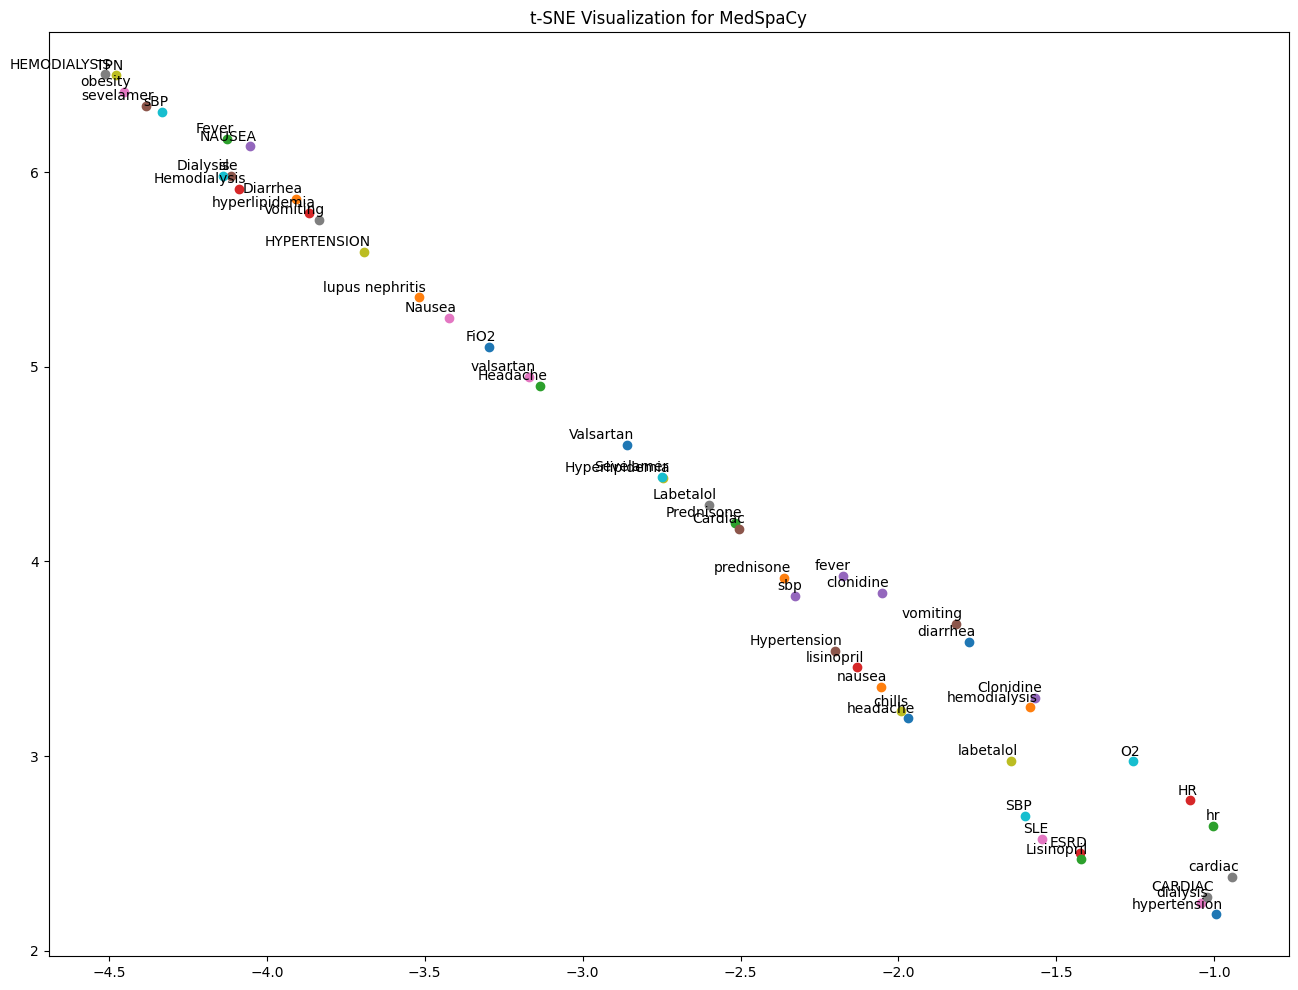

In [56]:
tsne_plot(model_word2vec_medspacy,np.array(list(model_word2vec_medspacy.wv.key_to_index.keys())), None, 'MedSpaCy')

In [57]:
len(model_word2vec_medspacy.wv.key_to_index.keys())

50

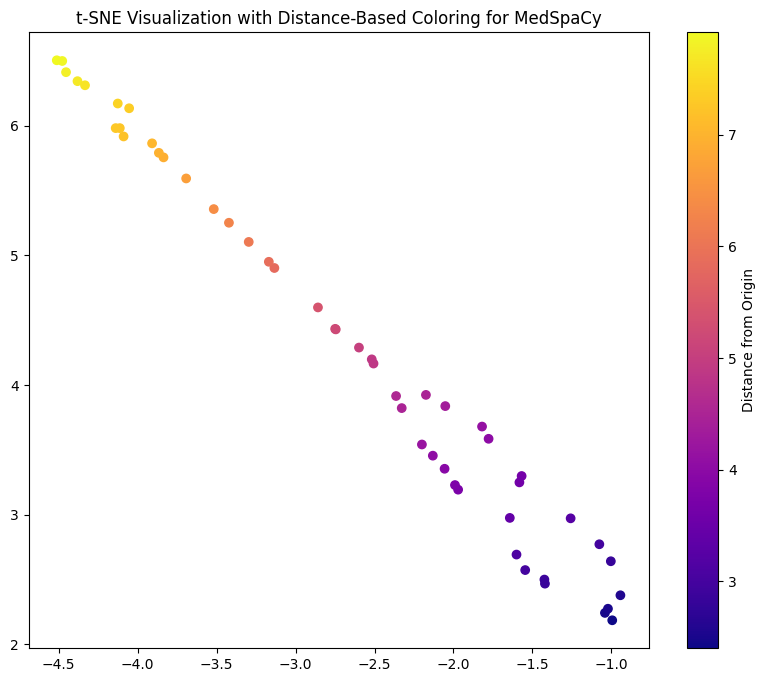

In [58]:
tsne_plot_no_label(model_word2vec_medspacy,np.array(list(model_word2vec_medspacy.wv.key_to_index.keys())), None, 'MedSpaCy')

### BlueBert


In [39]:
# Visualization of notes filtered with SciSpacy using ClinicalBert
import numpy as np
import torch
from sklearn.manifold import TSNE
import string
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer, BertModel

# Load the BERT model and tokenizer
model_name = "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12"
tokenizer = AutoTokenizer.from_pretrained(model_name)
blue_bert_model = BertModel.from_pretrained(model_name)
blue_bert_model.eval()

# Set first note as text
doc = nlp_SciSpaCy(patients_df_SciSpaCy['Processed_Text'][0])
corpus=[]
for ent in doc.ents:
    corpus.append(ent.text)
input_text =   ' '.join(corpus)

input_tokens = input_text.split()
word_embs = []

for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = blue_bert_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

525


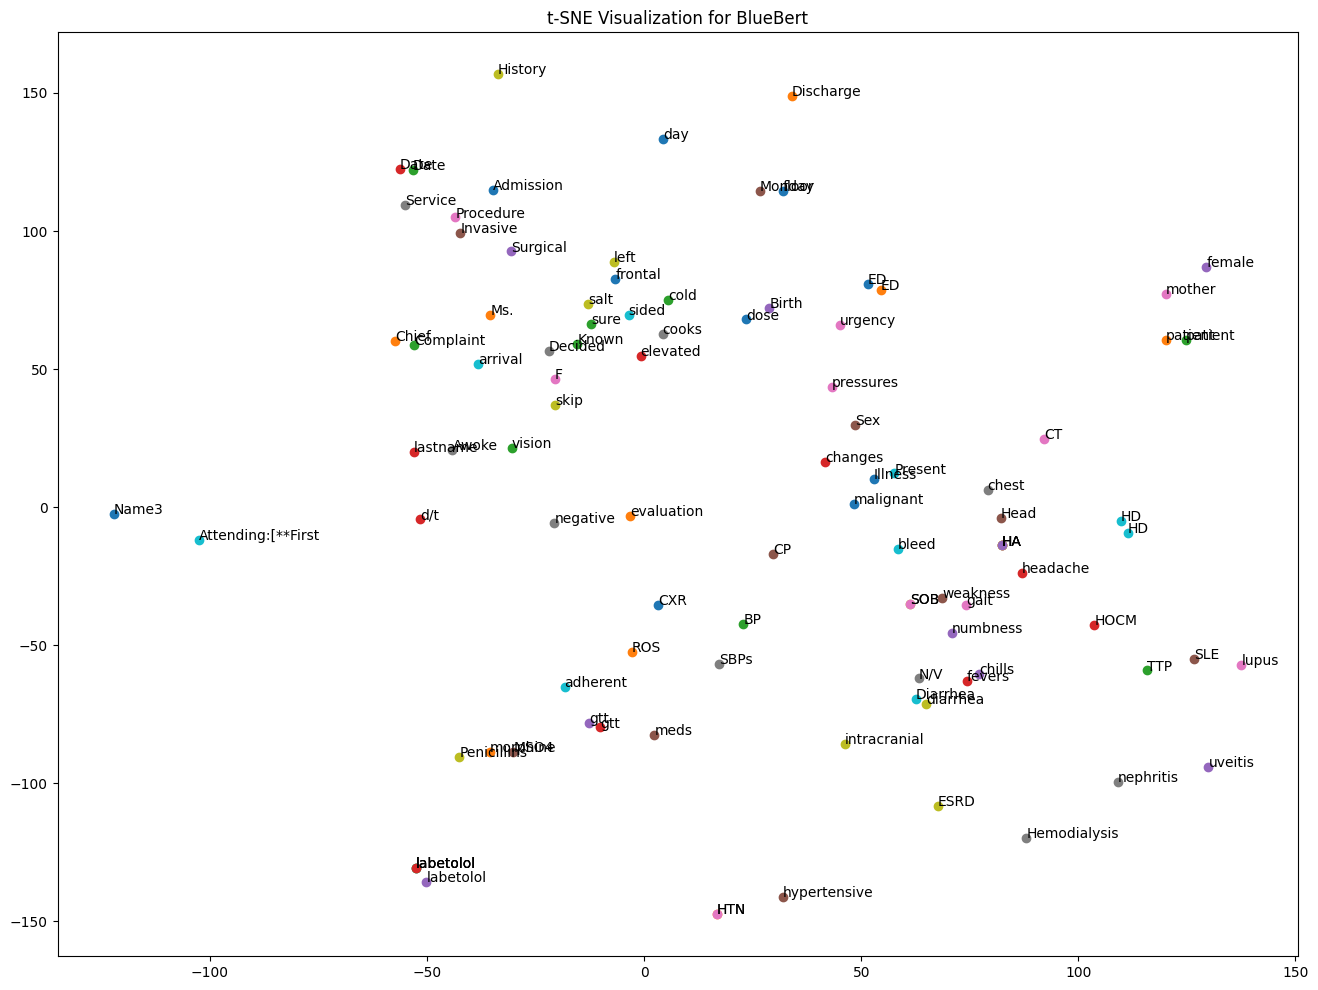

In [40]:
# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))
print(len(word_embs_2d))
# Create a scatter plot of the word embeddings in 2D space
plt.figure(figsize=(16,12))
for i in range(100):
    plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
    plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title(f"t-SNE Visualization for BlueBert")
plt.show()

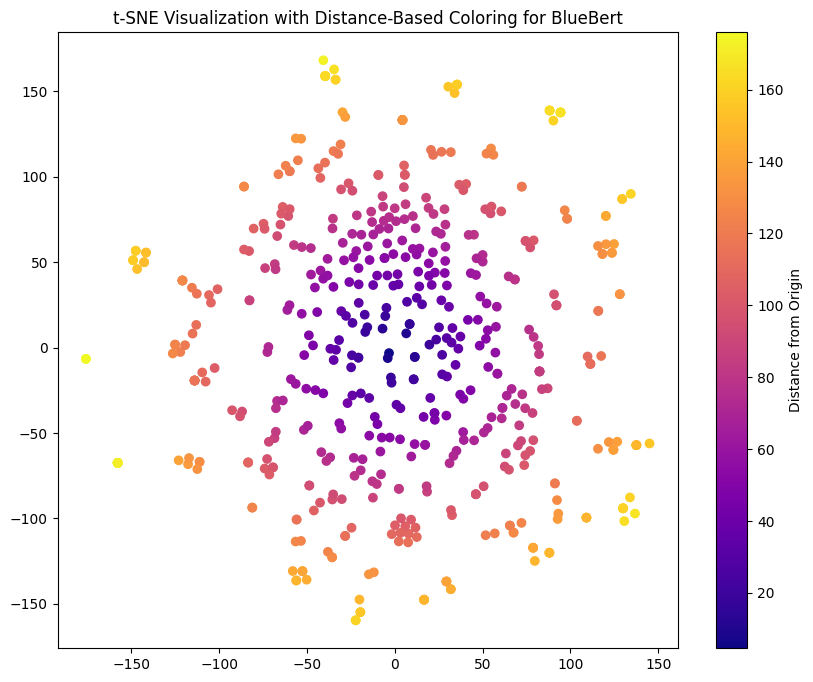

In [41]:
plt.figure(figsize=(10, 8))
distances = np.sqrt(word_embs_2d[:, 0]**2 + word_embs_2d[:, 1]**2)
plt.scatter(word_embs_2d[:, 0], word_embs_2d[:, 1], c=distances, cmap='plasma')
plt.colorbar(label="Distance from Origin")
plt.title(f"t-SNE Visualization with Distance-Based Coloring for BlueBert")
plt.show()